In [1]:
import xarray as xr
import numpy as np 
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import pandas as pd
import string
from src import config_cesm
from src.models.diagnostics import roll_metric
from src.utils import util_cesm
REFERENCE_GRID = util_cesm.generate_sps_grid()

def add_hatching(ax, significance_mask, x_edges, y_edges, hatch='///', edgecolor='k'):
    Ny, Nx = significance_mask.shape

    for i in range(Ny):
        for j in range(Nx):
            if significance_mask[i, j]:
                rect = mpatches.Rectangle(
                    (x_edges[j], y_edges[i]),
                    x_edges[j+1] - x_edges[j],
                    y_edges[i+1] - y_edges[i],
                    hatch=hatch,
                    fill=False,
                    edgecolor=edgecolor,
                    linewidth=0
                )
                ax.add_patch(rect)

def plot_markers(ax, exceeds_persistence, x_centers, y_centers):
    for i in range(6):
        for j in range(12):
            if not exceeds_persistence[i,j]:
                ax.plot(x_centers[j], y_centers[i], '.k', markersize=4) 


In [6]:
obs_persistence_acc = xr.open_dataset(os.path.join(config_cesm.PREDICTIONS_DIRECTORY, f"obs_input2_ensemble/diagnostics/acc_agg_persist.nc"))["acc"].squeeze()
obs_persistence_rmse = xr.open_dataset(os.path.join(config_cesm.PREDICTIONS_DIRECTORY, f"obs_input2_ensemble/diagnostics/rmse_agg_persist.nc"))["rmse"].squeeze()
obs_clim_rmse = xr.open_dataset(os.path.join(config_cesm.PREDICTIONS_DIRECTORY, f"obs_input2_ensemble/diagnostics/rmse_agg_climatology.nc"))["rmse"].squeeze()

cesm_persistence_acc = xr.open_dataset(os.path.join(config_cesm.PREDICTIONS_DIRECTORY, f"exp2_vol4/diagnostics/acc_agg_persist.nc"))["acc"].squeeze()
cesm_persistence_rmse = xr.open_dataset(os.path.join(config_cesm.PREDICTIONS_DIRECTORY, f"exp2_vol4/diagnostics/rmse_agg_persist.nc"))["rmse"].squeeze()
cesm_clim_rmse = xr.open_dataset(os.path.join(config_cesm.PREDICTIONS_DIRECTORY, f"exp2_vol4/diagnostics/rmse_agg_climatology.nc"))["rmse"].squeeze()

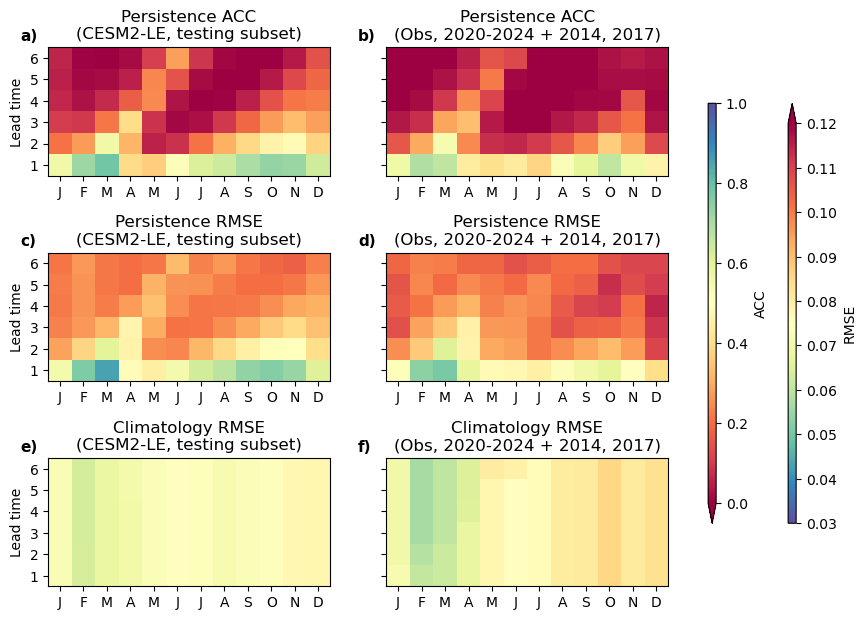

In [15]:
fig, axs = plt.subplots(3, 2, figsize=(8, 7), sharey=True)
x = np.arange(13)
y = np.arange(7)
x_centers = (x[:-1] + x[1:]) / 2
y_centers = (y[:-1] + y[1:]) / 2

ax = axs[0,0]
cax = ax.pcolormesh(x, y, cesm_persistence_acc, cmap='Spectral', shading='flat', vmin=0, vmax=1)
ax.set_title(f"Persistence ACC\n(CESM2-LE, testing subset)")

ax = axs[0,1]
ax.pcolormesh(x, y, obs_persistence_acc, cmap='Spectral', shading='flat', vmin=0, vmax=1)
ax.set_title(f"Persistence ACC\n(Obs, 2020-2024 + 2014, 2017)")

ax = axs[1,0]
cax2 = ax.pcolormesh(x, y, cesm_persistence_rmse, cmap='Spectral_r', shading='flat', vmin=0.03, vmax=0.12)
ax.set_title(f"Persistence RMSE\n(CESM2-LE, testing subset)")

ax = axs[1,1]
ax.pcolormesh(x, y, obs_persistence_rmse, cmap='Spectral_r', shading='flat', vmin=0.03, vmax=0.12)
ax.set_title(f"Persistence RMSE\n(Obs, 2020-2024 + 2014, 2017)")

ax = axs[2,0]
ax.pcolormesh(x, y, cesm_clim_rmse, cmap='Spectral_r', shading='flat', vmin=0.03, vmax=0.12)
ax.set_title(f"Climatology RMSE\n(CESM2-LE, testing subset)")

ax = axs[2,1]
ax.pcolormesh(x, y, obs_clim_rmse, cmap='Spectral_r', shading='flat', vmin=0.03, vmax=0.12)
ax.set_title(f"Climatology RMSE\n(Obs, 2020-2024 + 2014, 2017)")

for ax in axs[:,0]: ax.set_ylabel("Lead time")
for ax in axs.flatten():
    ax.set_yticks(y_centers, labels=np.arange(1,7,1))
    ax.set_xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])

plt.subplots_adjust(hspace=0.6)

cbar_ax = fig.add_axes([0.95, 0.2, 0.01, 0.6])
cbar_ax2 = fig.add_axes([1.05, 0.2, 0.01, 0.6])

plt.colorbar(cax, cax=cbar_ax, label=r'ACC', orientation='vertical', extend='min')
plt.colorbar(cax2, cax=cbar_ax2, label=r'RMSE', orientation='vertical', extend='max')

panel_labels = list(string.ascii_lowercase)
for i, ax in enumerate(axs.flatten()):
    ax.annotate(
        f"{panel_labels[i]})",
        xy=(0, 1), xycoords="axes fraction",
        xytext=(-0.1, 1.03), textcoords="axes fraction",
        ha="left", va="bottom",
        fontsize=11, fontweight="bold"
    )

plt.savefig("figures/cesm_new/supp_baseline_forecasts.pdf", bbox_inches='tight')